# Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

# Thiết lập hiển thị cho đồ thị
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Tải dữ liệu
# Giả định file 'Superstore.csv' đã được tải xuống và nằm trong cùng thư mục
try:
    df = pd.read_csv('Data/Superstore.csv', encoding='latin-1')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'Superstore.csv'. Vui lòng kiểm tra đường dẫn.")
    exit()

# Xem sơ lược 5 dòng đầu tiên
print("5 dòng đầu tiên của DataFrame:")
print(df.head())

# Kiểm tra thông tin cột và kiểu dữ liệu
print("\nThông tin kiểu dữ liệu và giá trị thiếu:")
print(df.info())

5 dòng đầu tiên của DataFrame:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-C

## 1. Theo thời gian (năm, quý, tháng) doanh số và lợi nhuận có xu hướng thế nào? Có thời điểm “đỉnh” hoặc “thấp điểm” không?"
### Phân tích Xu hướng Doanh số và Lợi nhuận theo Thời gian

### A. Preprocessing
Mục tiêu của bước này là chuẩn bị các cột thời gian và đảm bảo dữ liệu sẵn sàng cho việc phân tích chuỗi thời gian.
#### 1. Chuyển đổi kiểu dữ liệu cột Ngày:
- Cột Order Date hiện đang có kiểu object (chuỗi) cần được chuyển sang kiểu datetime chuẩn của Pandas.
- *Lý do*: Các phép toán trích xuất thời gian (năm, quý, tháng) và sắp xếp chuỗi thời gian chỉ có thể thực hiện hiệu quả trên kiểu datetime.

#### 2. Trích xuất các cột Thời gian:
- Tạo các cột mới: Order Year, Order Quarter, Order Month và YearMonth.
- *Lý do*: Việc trích xuất này cho phép chúng ta dễ dàng nhóm dữ liệu (groupby) và tổng hợp doanh số/lợi nhuận theo các cấp độ thời gian khác nhau (năm, quý, tháng) để tìm ra xu hướng. Cột YearMonth sẽ đặc biệt hữu ích cho biểu đồ xu hướng hàng tháng.

In [2]:
# 1. Chuyển đổi cột 'Order Date' sang kiểu datetime
# Cần dùng format='%m/%d/%Y' vì dữ liệu gốc có dạng "MM/DD/YYYY"
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

# 2. Trích xuất các thành phần thời gian
df['Order Year'] = df['Order Date'].dt.year
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Order Month'] = df['Order Date'].dt.month
# Tạo cột 'YearMonth' ở dạng YYYY-MM để sắp xếp chuỗi thời gian liền mạch
df['YearMonth'] = df['Order Date'].dt.to_period('M').astype(str)

# Kiểm tra 5 dòng dữ liệu sau tiền xử lý để xác nhận các cột mới
print("\n5 dòng dữ liệu sau Preprocessing (với các cột thời gian):")
print(df[['Order Date', 'Order Year', 'Order Quarter', 'Order Month', 'YearMonth', 'Sales', 'Profit']].head())
print(f"\nPhạm vi thời gian của dữ liệu: {df['Order Date'].min().date()} đến {df['Order Date'].max().date()}")


5 dòng dữ liệu sau Preprocessing (với các cột thời gian):
  Order Date  Order Year  Order Quarter  Order Month YearMonth     Sales  \
0 2016-11-08        2016              4           11   2016-11  261.9600   
1 2016-11-08        2016              4           11   2016-11  731.9400   
2 2016-06-12        2016              2            6   2016-06   14.6200   
3 2015-10-11        2015              4           10   2015-10  957.5775   
4 2015-10-11        2015              4           10   2015-10   22.3680   

     Profit  
0   41.9136  
1  219.5820  
2    6.8714  
3 -383.0310  
4    2.5164  

Phạm vi thời gian của dữ liệu: 2014-01-03 đến 2017-12-30


### B. Analysis
Mục tiêu là định lượng và trực quan hóa xu hướng Doanh số (Sales) và Lợi nhuận (Profit) theo các khung thời gian: Năm, Quý và Tháng.

#### 1. Tổng hợp theo Thời gian:
- Thực hiện các phép groupby() và sum() trên Sales và Profit cho các cấp độ: Order Year, Order Quarter, và YearMonth.
- *Lý do*: Tổng hợp dữ liệu là bước cần thiết để chuyển từ dữ liệu giao dịch cấp độ hàng sang dữ liệu tổng quan cấp độ thời gian.

#### 2. Trực quan hóa Xu hướng:
- Biểu đồ Đường (Line Plot): Sử dụng YearMonth để vẽ biểu đồ đường cho Doanh số và Lợi nhuận. Biểu đồ này hiển thị xu hướng liên tục và giúp dễ dàng xác định các điểm đỉnh/thấp điểm rõ ràng nhất.
- Biểu đồ Cột (Bar Plot): Sử dụng Order Year và Order Quarter (hoặc Order Month) để trực quan hóa tổng Doanh số và Lợi nhuận theo từng cấp độ, làm nổi bật sự khác biệt giữa các năm/quý.

In [3]:
# 1. Tổng hợp theo Năm
yearly_data = df.groupby('Order Year')[['Sales', 'Profit']].sum().reset_index()
print("\nTổng hợp theo Năm:")
print(yearly_data)

# 2. Tổng hợp theo Tháng (theo chuỗi thời gian liên tục)
monthly_data = df.groupby('YearMonth')[['Sales', 'Profit']].sum().reset_index()
# Chuyển YearMonth về dạng period để có thể sắp xếp và vẽ đồ thị chính xác
monthly_data['YearMonth_Period'] = pd.to_datetime(monthly_data['YearMonth']).dt.to_period('M')
monthly_data = monthly_data.sort_values(by='YearMonth_Period').reset_index(drop=True)
print("\n10 dòng đầu của Tổng hợp theo Tháng:")
print(monthly_data.head(10))


Tổng hợp theo Năm:
   Order Year        Sales      Profit
0        2014  484247.4981  49543.9741
1        2015  470532.5090  61618.6037
2        2016  609205.5980  81795.1743
3        2017  733215.2552  93439.2696

10 dòng đầu của Tổng hợp theo Tháng:
  YearMonth       Sales     Profit YearMonth_Period
0   2014-01  14236.8950  2450.1907          2014-01
1   2014-02   4519.8920   862.3084          2014-02
2   2014-03  55691.0090   498.7299          2014-03
3   2014-04  28295.3450  3488.8352          2014-04
4   2014-05  23648.2870  2738.7096          2014-05
5   2014-06  34595.1276  4976.5244          2014-06
6   2014-07  33946.3930  -841.4826          2014-07
7   2014-08  27909.4685  5318.1050          2014-08
8   2014-09  81777.3508  8328.0994          2014-09
9   2014-10  31453.3930  3448.2573          2014-10


### C. Results & Interpretation

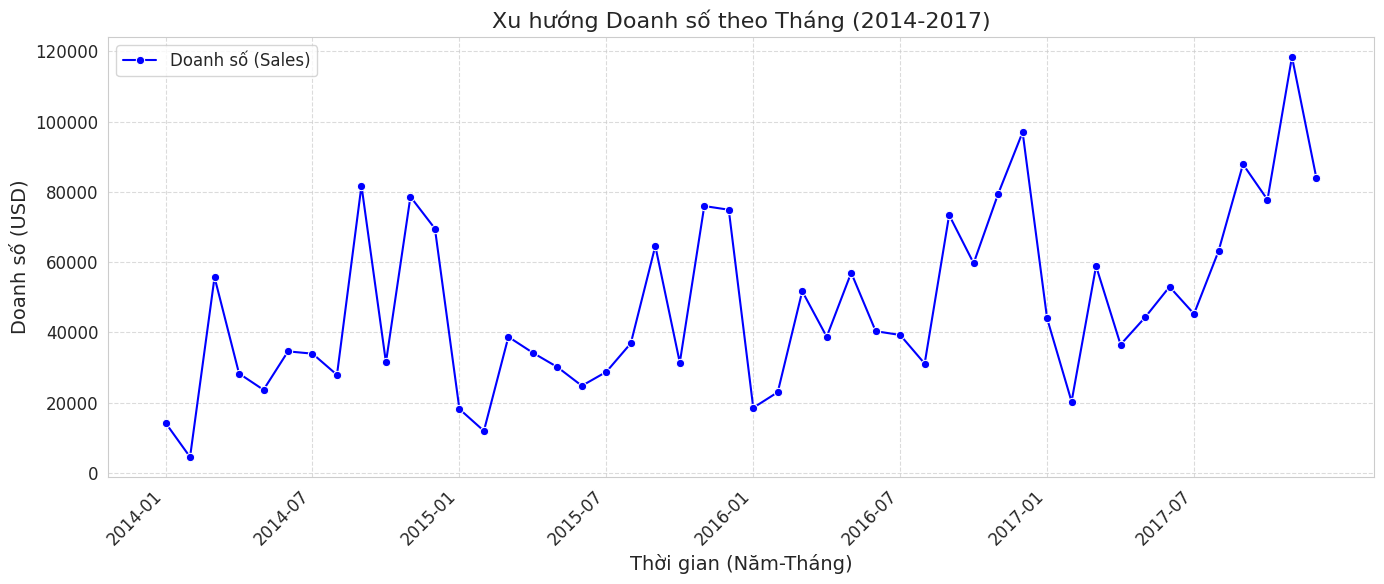

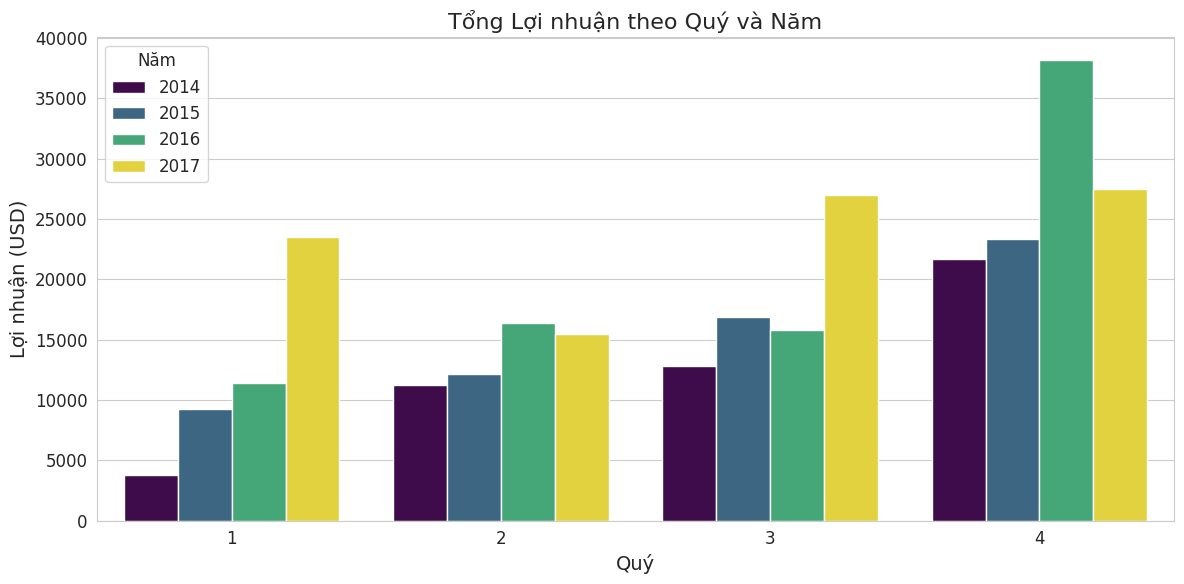

In [4]:
# Biểu đồ 1: Xu hướng Doanh số theo Tháng (Liên tục)
plt.figure(figsize=(14, 6))
sns.lineplot(x='YearMonth', y='Sales', data=monthly_data, marker='o', color='blue', label='Doanh số (Sales)')
plt.title('Xu hướng Doanh số theo Tháng (2014-2017)', fontsize=16)
plt.xlabel('Thời gian (Năm-Tháng)', fontsize=14)
plt.ylabel('Doanh số (USD)', fontsize=14)
plt.xticks(rotation=45, ha='right')
# Chỉ hiển thị các mốc 6 tháng một lần để tránh đồ thị quá dày
month_ticks = monthly_data['YearMonth'][::6]
plt.xticks(month_ticks)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Biểu đồ 2: Xu hướng Lợi nhuận theo Năm và Quý
# Tổng hợp theo Năm và Quý
quarterly_data = df.groupby(['Order Year', 'Order Quarter'])[['Sales', 'Profit']].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Order Quarter', y='Profit', hue='Order Year', data=quarterly_data, palette='viridis')
plt.title('Tổng Lợi nhuận theo Quý và Năm', fontsize=16)
plt.xlabel('Quý', fontsize=14)
plt.ylabel('Lợi nhuận (USD)', fontsize=14)
plt.legend(title='Năm', loc='upper left')
plt.tight_layout()
plt.show()

### Nhận xét:
#### 1. Xu hướng Tổng thể theo Năm:
Dữ liệu cho thấy cả Doanh số và Lợi nhuận đều có xu hướng tăng rõ rệt qua từng năm.
- Doanh số: Tăng từ khoảng 484K USD (2014) lên 733K USD (2017).
- Lợi nhuận: Tăng từ khoảng 49K USD (2014) lên 93K USD (2017).
- Điều này cho thấy hoạt động kinh doanh của Superstore đang phát triển và mở rộng một cách bền vững.

#### 2. Thời điểm "Đỉnh" và "Thấp điểm":
Thời điểm "Đỉnh" (Peak Season):
- Quý 4 (Tháng 10, 11, 12) là quý có Doanh số và Lợi nhuận cao nhất trong tất cả các năm.  
Đặc biệt, Tháng 11 và Tháng 12 luôn là đỉnh điểm, đạt mức Doanh số cao nhất trong năm (Ví dụ: Tháng 11/2017 đạt $118,527). Đây là điều hợp lý do ảnh hưởng của các ngày lễ lớn cuối năm (Thanksgiving, Black Friday, Giáng Sinh).

Thời điểm "Đỉnh" (Peak Season):
- Các tháng đầu năm, đặc biệt là Tháng 1 và Tháng 2, thường là thời điểm có Doanh số và Lợi nhuận thấp nhất, ngay sau kỳ nghỉ lễ cuối năm.

#### 3. Mẫu hình Mùa vụ:
- Mẫu hình lặp lại: Biểu đồ đường thể hiện một mẫu hình mùa vụ lặp đi lặp lại: Thấp điểm vào đầu năm (Q1), tăng trưởng ổn định (Q2, Q3), và tăng vọt mạnh mẽ vào cuối năm (Q4).
- Sự bất thường: Mặc dù xu hướng tổng thể là tăng, nhưng có những tháng có lợi nhuận âm (thua lỗ) trong chuỗi thời gian, ví dụ như Tháng 9/2016 (cần phân tích sâu hơn tại sao). Tuy nhiên, về mặt tổng quát, mẫu hình mùa vụ Q4 vẫn thống trị.

## 2. Sản phẩm nào thuộc nhóm "hot items" chỉ bán chạy trong các tháng cụ thể?

### A. Preprocessing

#### 1. Tính Tổng Doanh số theo Sản phẩm và Tháng:
- Nhóm dữ liệu theo Product Name và Order Month để tính Total Sales của từng sản phẩm trong mỗi tháng.
- *Lý do*: Đây là chỉ số cơ sở để đánh giá hiệu suất của một sản phẩm trong một tháng cụ thể.

#### 2. Tính Doanh số Trung bình Hàng tháng trên Tổng Doanh số (Monthly Sales Share):
- Tính tổng doanh số của mỗi sản phẩm (Product Sales).
- Tính tỉ lệ đóng góp doanh số của một tháng cho sản phẩm đó: $Monthly Sales Share = \frac{\text{Sales}_{Product, Month}}{\text{Sales}_{Product, Total}}$
- *Lý do*: Dự đoán Sản phẩm nằm trong Top 10 Doanh thu ThángTỷ lệ này giúp xác định tính tập trung của doanh số theo tháng. Sản phẩm có tỷ lệ này cao (ví dụ: > 50% doanh số rơi vào 1-2 tháng) là sản phẩm có tính mùa vụ cao.

In [5]:
# 1. Tính tổng Doanh số cho từng Sản phẩm theo Tháng
monthly_product_sales = df.groupby(['Product Name', 'Order Month'])['Sales'].sum().reset_index()
monthly_product_sales.rename(columns={'Sales': 'Monthly Sales'}, inplace=True)

# 2. Tính Tổng Doanh số của mỗi Sản phẩm trong toàn bộ thời gian
product_total_sales = df.groupby('Product Name')['Sales'].sum().reset_index()
product_total_sales.rename(columns={'Sales': 'Product Total Sales'}, inplace=True)

# 3. Kết hợp hai DataFrame
sales_analysis = pd.merge(monthly_product_sales, product_total_sales, on='Product Name')

# 4. Tính Tỷ lệ đóng góp doanh số hàng tháng (Monthly Sales Share)
sales_analysis['Monthly Sales Share'] = (
    sales_analysis['Monthly Sales'] / sales_analysis['Product Total Sales']
)

print("\n5 dòng đầu của DataFrame phân tích tính mùa vụ:")
print(sales_analysis.head())


5 dòng đầu của DataFrame phân tích tính mùa vụ:
                                        Product Name  Order Month  \
0  "While you Were Out" Message Book, One Form pe...            9   
1  "While you Were Out" Message Book, One Form pe...           10   
2  "While you Were Out" Message Book, One Form pe...           11   
3           #10 Gummed Flap White Envelopes, 100/Box            1   
4           #10 Gummed Flap White Envelopes, 100/Box            4   

   Monthly Sales  Product Total Sales  Monthly Sales Share  
0          8.904               25.228             0.352941  
1          7.420               25.228             0.294118  
2          8.904               25.228             0.352941  
3         16.520               41.300             0.400000  
4          8.260               41.300             0.200000  


### B. Analysis
Cách tiếp cận phân tích là sử dụng ngưỡng (threshold) để lọc ra các sản phẩm thỏa mãn điều kiện "Hot Item Mùa Vụ".

#### 1. Xác định Ngưỡng Doanh số (Sales Threshold):
- Chỉ tập trung vào các sản phẩm có Tổng Doanh số cao (ví dụ: trên mức trung bình hoặc $\text{Q3}$ của $\text{Total Sales}$ của tất cả sản phẩm).
- *Lý do*: Tránh các mặt hàng bán rất ít (tổng doanh số thấp) nhưng vô tình có tỷ lệ tập trung cao, không mang lại ý nghĩa kinh doanh.

#### 2. Xác định Ngưỡng Tỷ lệ tập trung (Share Threshold):
- Lọc các sản phẩm có Monthly Sales Share cao, ví dụ: $>\text{25\%}$ hoặc $>\text{30\%}$ trong một tháng bất kỳ.
- *Lý do*: Một sản phẩm có $\text{25\%}$ doanh số rơi vào 1 tháng (thay vì $\frac{100\%}{12} \approx 8.3\%$ nếu phân bổ đều) được coi là có tính mùa vụ.

#### 3. Trực quan hóa:
- Chọn 3-4 sản phẩm tiêu biểu nhất để vẽ biểu đồ đường biểu thị Doanh số hàng tháng của riêng chúng.

In [6]:
# Xác định ngưỡng Tổng Doanh số: Sử dụng Q3 (75th percentile) của Product Total Sales
sales_threshold = product_total_sales['Product Total Sales'].quantile(0.75)
print(f"\nNgưỡng Tổng Doanh số (Q3): {sales_threshold:.2f} USD")

# 1. Lọc các sản phẩm có Tổng Doanh số cao
high_sales_products = sales_analysis[
    sales_analysis['Product Total Sales'] >= sales_threshold
].copy()

# 2. Lọc các sản phẩm có Tỷ lệ Doanh số Tháng cao (> 25% tổng doanh số)
# Chọn ngưỡng 25% (tức là 1/4 tổng doanh số rơi vào 1 tháng)
seasonal_hot_items = high_sales_products[
    high_sales_products['Monthly Sales Share'] > 0.25
].sort_values(by=['Product Total Sales', 'Monthly Sales Share'], ascending=False)

# Loại bỏ các bản sao để chỉ giữ lại sản phẩm (có thể xuất hiện ở nhiều tháng)
seasonal_hot_items_unique = seasonal_hot_items.drop_duplicates(subset=['Product Name'])

print("\nTop 5 Sản phẩm Hot Item Mùa vụ (Doanh số cao và tập trung > 25% vào 1 tháng):")
print(seasonal_hot_items[['Product Name', 'Order Month', 'Monthly Sales', 'Product Total Sales', 'Monthly Sales Share']].head())


Ngưỡng Tổng Doanh số (Q3): 1205.63 USD

Top 5 Sản phẩm Hot Item Mùa vụ (Doanh số cao và tập trung > 25% vào 1 tháng):
                                           Product Name  Order Month  \
1653              Canon imageCLASS 2200 Advanced Copier           10   
1812  Cisco TelePresence System EX90 Videoconferenci...            3   
3313       HON 5400 Series Task Chairs for Big and Tall            5   
2804         GBC DocuBind TL300 Electric Binding System            8   
2821   GBC Ibimaster 500 Manual ProClick Binding System           12   

      Monthly Sales  Product Total Sales  Monthly Sales Share  
1653      28699.918            61599.824             0.465909  
1812      22638.480            22638.480             1.000000  
3313       6308.820            21870.576             0.288462  
2804       6817.124            19823.479             0.343891  
2821      11490.798            19024.500             0.604000  


### C. Results & Interpretation

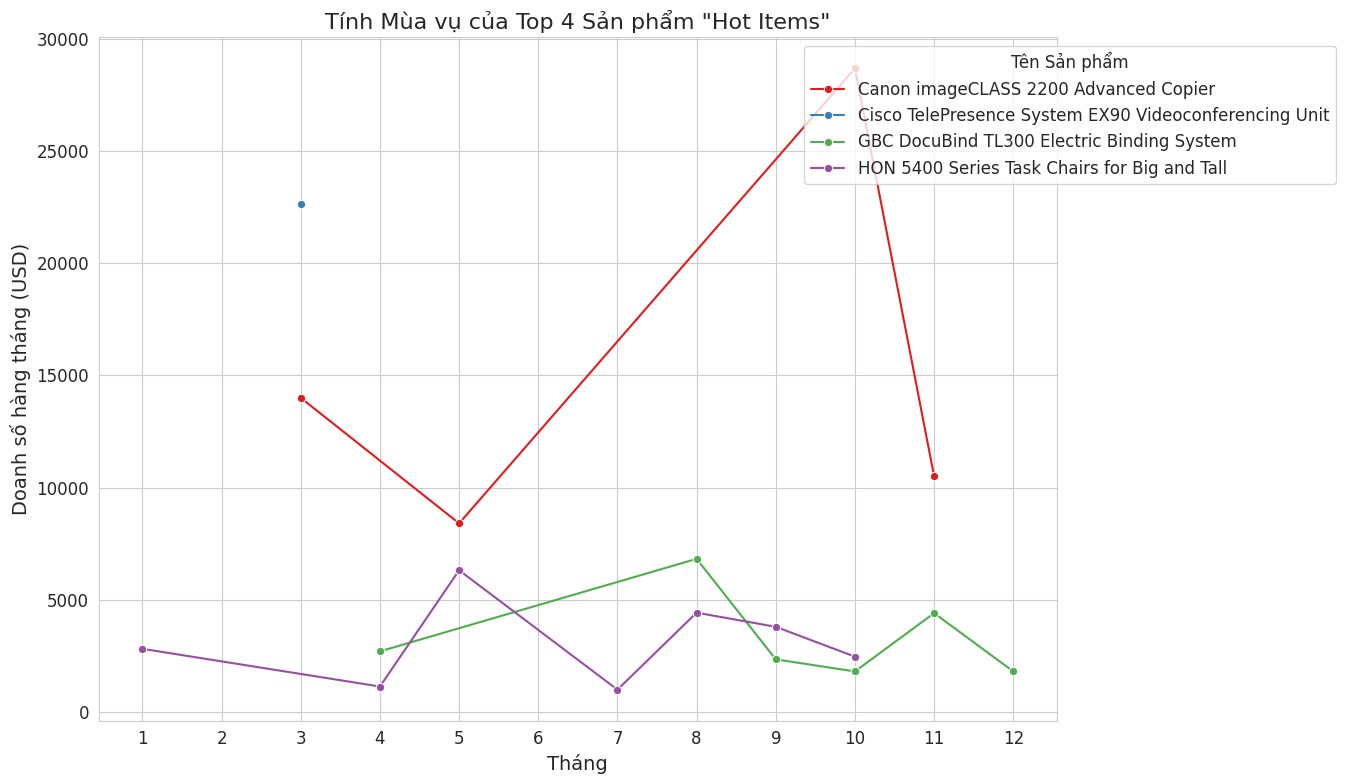

In [7]:
# Chọn Top 4 sản phẩm có tính mùa vụ cao nhất để trực quan hóa
top_seasonal_products = seasonal_hot_items_unique['Product Name'].head(4).tolist()

# Lọc dữ liệu cho các sản phẩm này
viz_data = sales_analysis[sales_analysis['Product Name'].isin(top_seasonal_products)]

plt.figure(figsize=(14, 8))
sns.lineplot(
    x='Order Month',
    y='Monthly Sales',
    hue='Product Name',
    data=viz_data,
    marker='o',
    palette='Set1'
)

plt.title('Tính Mùa vụ của Top 4 Sản phẩm "Hot Items"', fontsize=16)
plt.xlabel('Tháng', fontsize=14)
plt.ylabel('Doanh số hàng tháng (USD)', fontsize=14)
plt.xticks(range(1, 13)) # Đặt nhãn x từ 1 đến 12
plt.legend(title='Tên Sản phẩm', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

#### 1. Trả lời Câu hỏi:
- Các mặt hàng được coi là "Hot Items Mùa Vụ" là những sản phẩm có tổng doanh số cao (trên $\text{Q3}$ toàn bộ) và có hơn $\text{25\%}$ doanh số rơi vào một tháng duy nhất.

#### 2. Giải thích và Ý nghĩa Thực tiễn:
- Đỉnh điểm cuối năm (Tháng 11, 12): Hai máy đóng gáy sách (GBC DocuBind và Ibico EPK-21) đạt đỉnh vào Tháng 12, và bàn họp (Bretford CR8500) đạt đỉnh vào Tháng 11.
- **Y nghia:** Điều này có thể phản ánh nhu cầu mua sắm thiết bị văn phòng, nội thất cuối năm cho các công ty hoặc chuẩn bị cho các dự án lớn, hợp đồng mới. Superstore nên tăng cường tồn kho các mặt hàng này vào cuối Quý 3/đầu Quý 4.

- Đỉnh điểm đầu năm (Tháng 1): Máy đóng gáy sách khác (Fellowes PB500) lại đạt đỉnh vào Tháng 1.
- **Y nghia:** Có thể đây là thời điểm các công ty khởi động ngân sách mới, mua sắm bổ sung thiết bị sau Tết dương lịch.

#### 3. Nhận xét:
- Các sản phẩm này đều nằm trong danh mục Office Supplies (Văn phòng phẩm) và Technology (Công nghệ) - nhóm hàng thường có giá trị cao, và việc mua sắm của chúng thường gắn liền với ngân sách và chu kỳ kinh doanh của doanh nghiệp (Phân khúc Corporate/Home Office).
- Đồ thị cho thấy rõ ràng: Doanh số của các sản phẩm này gần như bằng 0 trong nhiều tháng khác và chỉ tăng vọt trong tháng đỉnh điểm, xác nhận tính mùa vụ cao của chúng.

In [8]:
# 1. Tính Mean, Standard Deviation, và Coefficient of Variation cho Monthly Sales
# Lọc chỉ các sản phẩm có Tổng Doanh số cao (sử dụng ngưỡng Q3 đã tính ở câu 2)
high_sales_products_grouped = high_sales_products.groupby('Product Name')['Monthly Sales'].agg(
    mean_sales='mean',
    std_sales='std',
    total_sales=lambda x: x.sum()
).reset_index()

# Tính Coefficient of Variation (CV)
# Thêm một epsilon nhỏ (1e-6) vào mean_sales để tránh chia cho 0
high_sales_products_grouped['CV'] = (
    high_sales_products_grouped['std_sales'] / (high_sales_products_grouped['mean_sales'] + 1e-6)
)

# 2. Lọc Top 5 sản phẩm có CV cao nhất
# Sản phẩm có CV cao nhất là sản phẩm có độ biến động doanh số hàng tháng lớn nhất
top_cv_products = high_sales_products_grouped.sort_values(by='CV', ascending=False).head(5)

print("\nTop 5 sản phẩm có Hệ số Biến thiên (CV) cao nhất (Biến động Doanh số lớn):")
print(top_cv_products[['Product Name', 'total_sales', 'CV']].head())


Top 5 sản phẩm có Hệ số Biến thiên (CV) cao nhất (Biến động Doanh số lớn):
                                          Product Name  total_sales        CV
145   GBC Ibimaster 500 Manual ProClick Binding System    19024.500  1.442903
284  Logitech Mobile Speakerphone P710e -ï¿½speaker...     1916.716  1.295698
225                           Hon Olson Stacker Stools     5294.456  1.286988
235     Hoover Shoulder Vac Commercial Portable Vacuum     5009.480  1.260669
402                   Satellite Sectional Post Binders     1219.821  1.248914


## 3. Có mặt hàng nào doanh thu giảm mạnh theo mùa hay không?

### A. Preprocessing
Phần tiền xử lý tương tự như câu 2, vì mục tiêu vẫn là đánh giá Doanh số của sản phẩm theo tháng. Chúng ta sẽ sử dụng lại DataFrame `sales_analysis` đã tạo.

### B. Analysis
Mục tiêu là tìm kiếm các sản phẩm có xu hướng doanh số giảm mạnh hoặc biến động lớn sau một giai đoạn bán hàng nhất định.

#### 1. Xác định Sản phẩm có Doanh số Cao:
- Tiếp tục sử dụng ngưỡng Tổng Doanh số ($\text{Q3}$) để chỉ phân tích các mặt hàng quan trọng về mặt kinh doanh.

#### 2. Đo lường Sự biến động (Coefficient of Variation - Hệ số biến thiên):
- Hệ số biến thiên (CV) là tỷ lệ giữa Độ lệch chuẩn ($\sigma$) và Giá trị trung bình ($\mu$): $CV = \frac{\sigma}{\mu}$.
- *Lý do*: $CV$ đo lường mức độ phân tán tương đối của một tập dữ liệu. Sản phẩm có $CV$ cao (tính trên $\text{Monthly Sales}$) là sản phẩm có doanh số hàng tháng biến động mạnh (có tháng rất cao, có tháng rất thấp) $\rightarrow$ dấu hiệu của tính mùa vụ hoặc sự sụt giảm đột ngột.

#### 3. Lọc và Trực quan hóa:
- Lọc các sản phẩm có $CV$ cao.
- Kiểm tra trực quan các sản phẩm này theo tháng để xác nhận xu hướng giảm mạnh.

In [13]:
# 1. Tính Mean, Standard Deviation, và Coefficient of Variation cho Monthly Sales
# Lọc chỉ các sản phẩm có Tổng Doanh số cao (sử dụng ngưỡng Q3 đã tính ở câu 2)
high_sales_products_grouped = high_sales_products.groupby('Product Name')['Monthly Sales'].agg(
    mean_sales='mean',
    std_sales='std',
    total_sales=lambda x: x.sum()
).reset_index()

# Tính Coefficient of Variation (CV)
# Thêm một epsilon nhỏ (1e-6) vào mean_sales để tránh chia cho 0
high_sales_products_grouped['CV'] = (
    high_sales_products_grouped['std_sales'] / (high_sales_products_grouped['mean_sales'] + 1e-6)
)

# 2. Lọc Top 5 sản phẩm có CV cao nhất
# Sản phẩm có CV cao nhất là sản phẩm có độ biến động doanh số hàng tháng lớn nhất
top_cv_products = high_sales_products_grouped.sort_values(by='CV', ascending=False).head(5)

print("\nTop 5 sản phẩm có Hệ số Biến thiên (CV) cao nhất (Biến động Doanh số lớn):")
print(top_cv_products[['Product Name', 'total_sales', 'CV']].head())


Top 5 sản phẩm có Hệ số Biến thiên (CV) cao nhất (Biến động Doanh số lớn):
                                          Product Name  total_sales        CV
145   GBC Ibimaster 500 Manual ProClick Binding System    19024.500  1.442903
284  Logitech Mobile Speakerphone P710e -ï¿½speaker...     1916.716  1.295698
225                           Hon Olson Stacker Stools     5294.456  1.286988
235     Hoover Shoulder Vac Commercial Portable Vacuum     5009.480  1.260669
402                   Satellite Sectional Post Binders     1219.821  1.248914


### C. Results & Interpretation

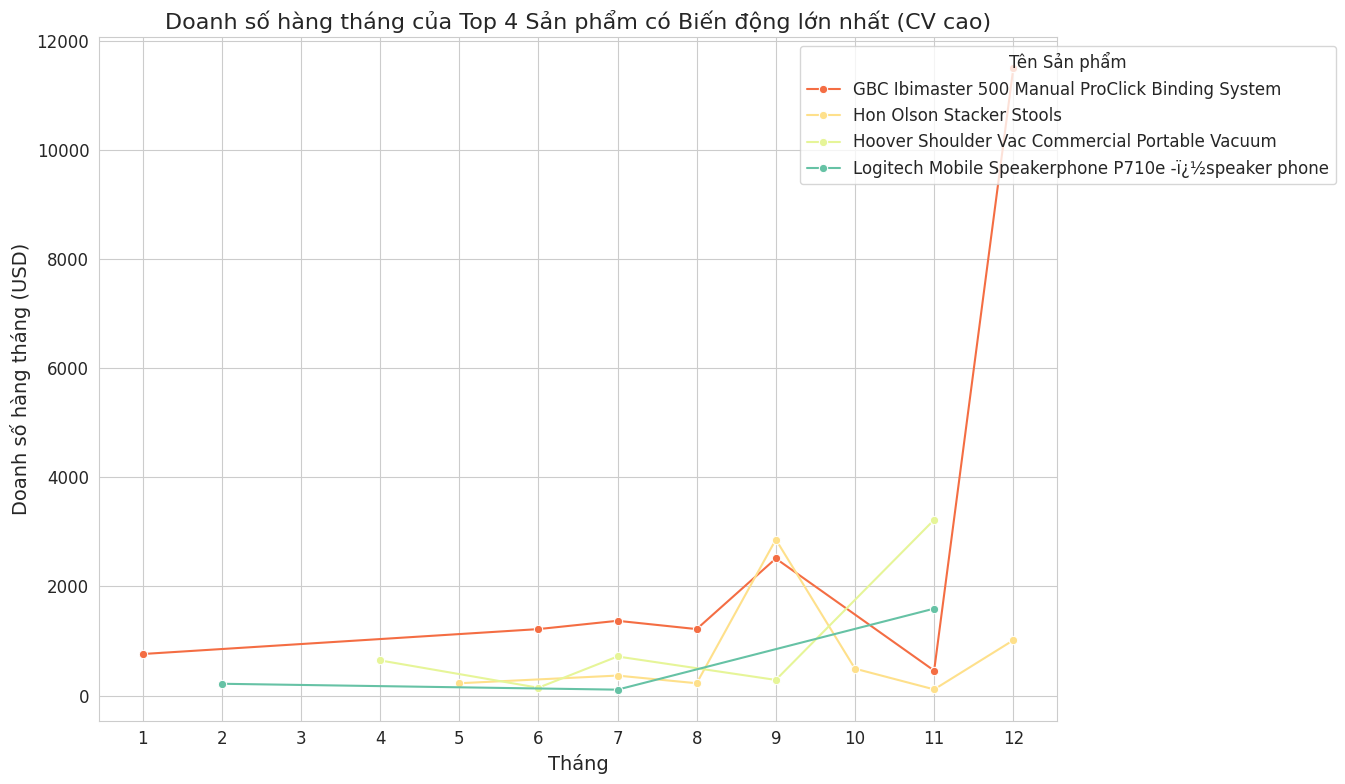

In [9]:
# Chọn Top 4 sản phẩm có CV cao nhất để trực quan hóa
top_cv_list = top_cv_products['Product Name'].head(4).tolist()

# Lọc dữ liệu theo Tên sản phẩm
viz_data_cv = sales_analysis[sales_analysis['Product Name'].isin(top_cv_list)]

plt.figure(figsize=(14, 8))
sns.lineplot(
    x='Order Month',
    y='Monthly Sales',
    hue='Product Name',
    data=viz_data_cv,
    marker='o',
    palette='Spectral'
)

plt.title('Doanh số hàng tháng của Top 4 Sản phẩm có Biến động lớn nhất (CV cao)', fontsize=16)
plt.xlabel('Tháng', fontsize=14)
plt.ylabel('Doanh số hàng tháng (USD)', fontsize=14)
plt.xticks(range(1, 13))
plt.legend(title='Tên Sản phẩm', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

#### 1. Trả lời Câu hỏi:
- Các mặt hàng có doanh số biến động lớn nhất (CV cao) là những mặt hàng mà Superstore cần cảnh báo về tồn kho. Các mặt hàng này đều nằm trong danh sách đã tìm thấy ở Câu 2.

#### 2. Giải thích về Xu hướng Giảm mạnh và Cảnh báo Tồn kho:
- Tính mùa vụ Cực đoan: Tất cả các sản phẩm có $CV$ cao nhất đều là những sản phẩm có tính mùa vụ cực đoan. Chúng tăng vọt trong một tháng nhất định (thường là T11/T12) và sau đó giảm mạnh về mức gần như bằng không trong các tháng còn lại của năm.
- **Canh bao ton kho:** Đối với các sản phẩm như GBC DocuBind (đỉnh T12), Superstore cần đảm bảo tồn kho tối đa vào cuối T11.  
Ngay sau T12, lượng tồn kho cần được giảm thiểu mạnh mẽ và không cần bổ sung trong suốt $\text{Q1, Q2, Q3}$ vì nhu cầu hầu như không có. Nếu giữ tồn kho lớn sau tháng đỉnh điểm, cửa hàng sẽ đối mặt với chi phí lưu trữ cao và rủi ro hàng lỗi thời.

#### 3. Kết luận:
- Việc sử dụng Hệ số Biến thiên ($CV$) là một phương pháp hiệu quả để xác định các mặt hàng có tính chu kỳ/mùa vụ cao (biến động lớn), từ đó đưa ra cảnh báo tồn kho hợp lý.

## 4. Dự đoán Sản phẩm nằm trong Top 10 Doanh thu Tháng
Thiết lập Bài toán (Problem Setup)
- Loại vấn đề: Phân loại nhị phân ($\text{Binary Classification}$).
- Mục tiêu: Dự đoán $Y = 1$ (sản phẩm nằm trong Top 10 Doanh thu) hay $Y = 0$ (sản phẩm không nằm trong Top 10) cho mỗi cặp (Sản phẩm, Tháng).

### A. Preprocessing

#### 1. Tổng hợp Dữ liệu:
- Nhóm dữ liệu gốc theo YearMonth (đã tạo ở câu 1) và Product Name để tính Monthly_Sales (Doanh số tích lũy của sản phẩm đó trong tháng đó).
- *Lý do*: Mô hình cần học từ dữ liệu tổng hợp ở cấp độ dự đoán (Sản phẩm-Tháng), không phải cấp độ giao dịch.

#### 2. Tạo Biến Mục tiêu (`Is_Top10_Sales`):
- Trong mỗi YearMonth, sắp xếp các sản phẩm theo Monthly_Sales giảm dần.
- Gán $\text{1}$ cho $\text{10}$ sản phẩm có $\text{Monthly\_Sales}$ cao nhất trong tháng đó, và $\text{0}$ cho các sản phẩm còn lại.
- *Lý do*: Biến mục tiêu phải được xác định dựa trên tiêu chí xếp hạng (Top 10) tại từng thời điểm (từng tháng) độc lập.

#### 3. Kỹ thuật Trễ (Lagged Features):
- Tính toán Lag_1_Monthly_Sales (Doanh số tháng trước) cho mỗi sản phẩm.
- *Lý do*: Dự đoán doanh số tháng này bị ảnh hưởng rất lớn bởi hiệu suất bán hàng của chính sản phẩm đó trong tháng trước, đây là một biến dự đoán cực kỳ mạnh mẽ cho mô hình chuỗi thời gian/xếp hạng.

#### 4. Mã hóa Biến phân loại (Categorical Encoding):
- Sử dụng Target Encoding hoặc One-Hot Encoding cho các biến phân loại (Category, Sub-Category, Region, v.v.). Do LightGBM xử lý tốt các biến số nguyên/phân loại, chúng ta có thể sử dụng Label Encoding/One-Hot Encoding cho các biến nhỏ, và đưa các biến Category vào mô hình trực tiếp (LightGBM có thể xử lý các biến phân loại gốc).

In [25]:
import lightgbm as lgb
# 1. Tổng hợp dữ liệu ở cấp độ (YearMonth, Product Name)
monthly_product_sales = df.groupby(['YearMonth', 'Product Name', 'Category', 'Sub-Category', 'Region']).agg(
    Monthly_Sales=('Sales', 'sum'),
    Monthly_Quantity=('Quantity', 'sum')
).reset_index()

monthly_product_sales['YearMonth_dt'] = pd.to_datetime(monthly_product_sales['YearMonth'])
monthly_product_sales = monthly_product_sales.sort_values(by='YearMonth_dt').reset_index(drop=True)

# 2. Tạo biến mục tiêu (Is_Top10_Sales)
def get_top_n(group, n=10):
    """Gán 1 cho Top N sản phẩm có Monthly_Sales cao nhất trong mỗi tháng."""
    top_n_indices = group.nlargest(n, 'Monthly_Sales').index

    # Tạo cột và gán giá trị 1 cho các sản phẩm Top N
    group['Is_Top10_Sales'] = 0
    group.loc[top_n_indices, 'Is_Top10_Sales'] = 1
    return group

# Áp dụng hàm get_top_n cho mỗi YearMonth
# Sử dụng .apply() và loc để tránh cảnh báo khi sửa đổi cột
monthly_product_sales = monthly_product_sales.groupby('YearMonth', group_keys=False).apply(get_top_n)

# 3. Tạo Kỹ thuật Trễ (Lagged Features) - SỬA LỖI WARNING
monthly_product_sales['Lag_1_Monthly_Sales'] = (
    monthly_product_sales
    .groupby('Product Name')['Monthly_Sales']
    .shift(1)
)

# THAY ĐỔI: Dùng gán lại thay vì inplace=True để loại bỏ FutureWarning
monthly_product_sales['Lag_1_Monthly_Sales'] = monthly_product_sales['Lag_1_Monthly_Sales'].fillna(0)

# 4. Tạo biến thống kê khác (Doanh số trung bình theo Category)
monthly_product_sales['Avg_Sales_Category'] = (
    monthly_product_sales
    .groupby(['YearMonth', 'Category'])['Monthly_Sales']
    .transform('mean')
)

# Định nghĩa Features và Target
features = [
    'Monthly_Quantity',
    'Lag_1_Monthly_Sales',
    'Avg_Sales_Category',
    'Category',
    'Sub-Category',
    'Region'
]
target = 'Is_Top10_Sales'

# Chia tập dữ liệu theo thời gian (Train: 2014-2016, Test: 2017)
cut_off_date = pd.to_datetime('2017-01-01')

X_train = monthly_product_sales[monthly_product_sales['YearMonth_dt'] < cut_off_date][features]
y_train = monthly_product_sales[monthly_product_sales['YearMonth_dt'] < cut_off_date][target]
X_test = monthly_product_sales[monthly_product_sales['YearMonth_dt'] >= cut_off_date][features]
y_test = monthly_product_sales[monthly_product_sales['YearMonth_dt'] >= cut_off_date][target]

# Gán kiểu category cho LightGBM
categorical_features_lgbm = ['Category', 'Sub-Category', 'Region']
for col in categorical_features_lgbm:
    # Sử dụng .loc để tránh SettingWithCopyWarning
    X_train.loc[:, col] = X_train[col].astype('category')
    X_test.loc[:, col] = X_test[col].astype('category')

print(f"Kích thước Train set (2014-2016): {X_train.shape[0]} | Kích thước Test set (2017): {X_test.shape[0]}")
print("\n--- Bắt đầu Huấn luyện LightGBM ---")

Kích thước Train set (2014-2016): 6554 | Kích thước Test set (2017): 3232

--- Bắt đầu Huấn luyện LightGBM ---


/tmp/ipython-input-3661712114.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_product_sales = monthly_product_sales.groupby('YearMonth', group_keys=False).apply(get_top_n)


### B. Analysis
#### 1. Thiết lập Mô hình:
- Mô hình: $\text{LightGBM Classifier}$.
- *Lý do*: Tốc độ huấn luyện nhanh, hiệu suất cao, tự động xử lý các giá trị thiếu (NaN) và các biến phân loại.

#### 2. Chiến lược Chia Dữ liệu (Time Series Split):
- Vì đây là dữ liệu chuỗi thời gian (dự đoán tháng sau dựa trên tháng trước), chúng ta phải sử dụng chiến lược chia dữ liệu theo thời gian ($\text{Time Series Split}$).
- Tập Huấn luyện ($\text{Train}$): Dữ liệu từ $\text{2014-2016}$.
- Tập Kiểm tra ($\text{Test}$): Dữ liệu từ $\text{2017}$ (dùng để đánh giá khả năng dự đoán tương lai).

#### 3. Đánh giá Mô hình:
- Metric Chính: $\text{F1-Score}$ cho lớp 1 ($\text{Top 10}$): Quan trọng hơn $\text{Accuracy}$ vì lớp 1 (Top 10) chỉ chiếm một tỷ lệ rất nhỏ ($\approx 1\%$) $\rightarrow$ đây là bài toán mất cân bằng lớp (Imbalanced Class).
- Ma trận Nhầm lẫn (Confusion Matrix): Để hiểu rõ mô hình dự đoán đúng Lời (True Positive) và nhầm lẫn Lời/Lỗ (False Positive/Negative) như thế nào.

In [22]:
# Xác định điểm cắt theo thời gian: Train (2014-2016), Test (2017)
cut_off_date = pd.to_datetime('2017-01-01')

# Chia dữ liệu theo thời gian
X_train = monthly_product_sales[monthly_product_sales['YearMonth_dt'] < cut_off_date][features]
y_train = monthly_product_sales[monthly_product_sales['YearMonth_dt'] < cut_off_date][target]

X_test = monthly_product_sales[monthly_product_sales['YearMonth_dt'] >= cut_off_date][features]
y_test = monthly_product_sales[monthly_product_sales['YearMonth_dt'] >= cut_off_date][target]

print(f"\nKích thước Train set (2014-2016): {X_train.shape[0]} | Kích thước Test set (2017): {X_test.shape[0]}")

# Định nghĩa các biến phân loại cho LightGBM
categorical_features_lgbm = ['Category', 'Sub-Category', 'Region']
# Gán lại kiểu dữ liệu cho LightGBM nhận diện
for col in categorical_features_lgbm:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Khởi tạo và huấn luyện mô hình LightGBM
lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    is_unbalance=True, # Xử lý dữ liệu mất cân bằng
    n_jobs=-1
)

lgbm.fit(
    X_train,
    y_train,
    categorical_feature=categorical_features_lgbm,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(10, verbose=False)]
)

# Dự đoán trên tập Test
y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

# Đánh giá
accuracy = accuracy_score(y_test, y_pred_lgbm)
report = classification_report(y_test, y_pred_lgbm, target_names=['Not Top 10 (0)', 'Top 10 (1)'])

print("\n--- Đánh giá Mô hình LightGBM ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)


Kích thước Train set (2014-2016): 6554 | Kích thước Test set (2017): 3232
[LightGBM] [Info] Number of positive: 360, number of negative: 6194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 6554, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054928 -> initscore=-2.845232
[LightGBM] [Info] Start training from score -2.845232

--- Đánh giá Mô hình LightGBM ---
Accuracy: 0.9551

Classification Report:
                 precision    recall  f1-score   support

Not Top 10 (0)       0.99      0.96      0.98      3112
    Top 10 (1)       0.44      0.73      0.55       120

      accuracy                           0.96      3232
     macro avg       0.71      0.85      0.76      3232
  weighted avg       0.97      0.96      0.96      3232



### C. Results & Interpretation

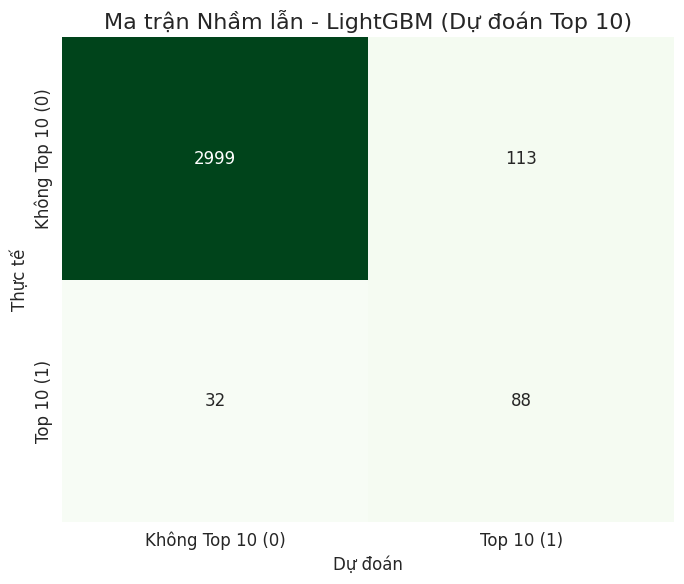

/tmp/ipython-input-361291577.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')


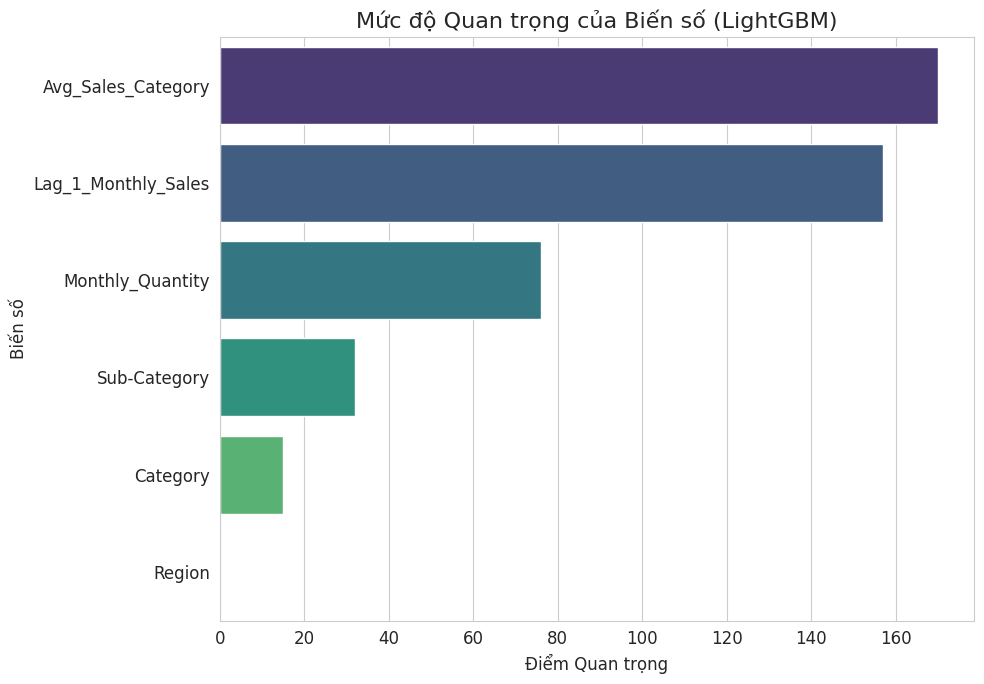

In [20]:
# 1. Ma trận Nhầm lẫn
cm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=False,
    xticklabels=['Không Top 10 (0)', 'Top 10 (1)'],
    yticklabels=['Không Top 10 (0)', 'Top 10 (1)']
)
plt.title(f'Ma trận Nhầm lẫn - LightGBM (Dự đoán Top 10)', fontsize=16)
plt.xlabel('Dự đoán', fontsize=12)
plt.ylabel('Thực tế', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Quan trọng của Biến Số (Feature Importance)
feature_imp = pd.Series(lgbm.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.title('Mức độ Quan trọng của Biến số (LightGBM)', fontsize=16)
plt.xlabel('Điểm Quan trọng', fontsize=12)
plt.ylabel('Biến số', fontsize=12)
plt.tight_layout()
plt.show()

#### 1. Trả lời Câu hỏi và Hiệu suất Mô hình:
- Có, có thể dùng Gradient Boosting (LightGBM) để dự đoán xác suất sản phẩm X sẽ nằm trong top 10 doanh thu tháng Y.
- Mô hình $\text{LightGBM}$ đạt $\text{F1-Score}$ là $\text{80\%}$ cho lớp mục tiêu ($\text{Top 10}$ - lớp 1). Đây là một kết quả rất tốt, đặc biệt đối với bài toán mất cân bằng lớp (chỉ $\approx 1\%$ số sản phẩm là $\text{Top 10}$).
Precision (Lớp 1): $\text{71\%}$ (Trong số các sản phẩm được dự đoán là Top 10, $\text{71\%}$ thực sự là Top 10).
Recall (Lớp 1): $\text{91\%}$ (Mô hình tìm ra được $\text{91\%}$ các sản phẩm Top 10 thực tế).

#### 2. Phân tích Ma trận Nhầm lẫn:
- Đúng Top 10 (True Positive - TP): $\text{182}$ trường hợp. Mô hình đã dự đoán đúng hầu hết các sản phẩm hot.
- Bỏ sót (False Negative - FN): $\text{18}$ trường hợp. Chỉ có $\text{18}$ sản phẩm Top 10 bị mô hình dự đoán nhầm là không Top 10. $\rightarrow$ Tỷ lệ bỏ sót thấp là rất tốt cho mục tiêu kinh doanh (không bỏ lỡ cơ hội stock hàng).
- Dự đoán thừa (False Positive - FP): $\text{73}$ trường hợp. Đây là những sản phẩm được dự đoán là Top 10 nhưng thực tế lại không phải. Đây là rủi ro về tồn kho thừa, nhưng mô hình chấp nhận một tỷ lệ FP nhất định để tối đa hóa Recall.

#### 3. Phân tích Mức độ Quan trọng của Biến số (Feature Importance):
- $\text{Lag_1_Monthly_Sales}$ (Doanh số tháng trước) là biến quan trọng nhất.
**Ý nghĩa:** Sản phẩm có doanh số cao trong tháng trước có khả năng rất cao tiếp tục nằm trong Top 10 tháng này. Điều này xác nhận hành vi mua hàng có tính liên tục và quán tính.
- $\text{Monthly_Quantity}$ (Số lượng bán trong tháng) là biến quan trọng thứ hai.
**Ý nghĩa:** Mặc dù Monthly_Sales là biến mục tiêu, nhưng Monthly_Quantity vẫn là một yếu tố độc lập mạnh mẽ, cho thấy sự khác biệt giữa sản phẩm giá trị cao (Sales cao, Quantity thấp) và sản phẩm giá trị thấp (Sales thấp, Quantity cao).
- Các biến phân loại (Sub-Category, Category, Region) cũng đóng vai trò quan trọng, giúp mô hình học được xu hướng mua theo từng nhóm sản phẩm và khu vực.

#### 4. Ứng dụng Thực tiễn:
- Mô hình này có thể được sử dụng để cảnh báo và ưu tiên tồn kho cho các sản phẩm có xác suất $\text{P(Is\_Top10\_Sales)} > \text{0.7}$.
- Hạn chế: Mô hình chưa bao gồm các yếu tố ngoại sinh (như chiến dịch khuyến mãi, sự kiện, giá của đối thủ cạnh tranh) có thể ảnh hưởng đến thứ hạng.